# Plant Seedlings Classification - Tensorflow Project

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
import glob
from IPython.display import Image
import cv2
#http://stackabuse.com/tensorflow-save-and-restore-models/

In [2]:
IMG_SIZE = (150, 150)

## Data

### - One Hot labels

In [3]:
dirs = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
       'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
values = np.array(dirs)
# print(values,'\n')

#transformando em one hot
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encodeded = np.array(onehot_encoder.fit_transform(integer_encoded)).astype(int)
# print(onehot_encodeded)

### - Training Data

In [4]:
training_path = '../data/SeedlingData/train/'
training_data = []
__ = -1;
for img_class in dirs:
    __ += 1
    _=0;
    for filename in glob.glob(training_path+img_class+'/*.png'):
        im = cv2.imread(filename)
        im = np.array(cv2.resize(im, IMG_SIZE)).ravel()
        training_data.append([im, onehot_encodeded[__]])
#         if _==0:
#             display(Image(filename, width=80, height=80))
#             print(filename)
#             print(onehot_encodeded[__])
#         _+= 1
random.shuffle(training_data)

### - Test Data

In [5]:
test_path = '../data/SeedlingData/test/'
test_data = []
for filename in glob.glob(test_path+'/*.png'):
    im = cv2.imread(filename)
    im = np.array(cv2.resize(im, IMG_SIZE)).ravel()
    test_data.append([im, filename.split('/')[-1]])

### Building Model

In [6]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(init_random_dist)

In [7]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [8]:
def conv2d(x, W):
    #x -> [batch, H, W, Channels]
    #W -> [filter H, filter W, Channels IN, Channels Out]
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='SAME')

In [9]:
def max_pool_2by2(x):
    #x -> [batch, H, W, Channels]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides = [1,2,2,1], padding='SAME')

In [10]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W)+b)

In [11]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [12]:
# placeholders
x = tf.placeholder(tf.float32, shape=[None, IMG_SIZE[0]*IMG_SIZE[1]*3])
y_ = tf.placeholder(tf.float32, shape=[None, 12])

In [13]:
#layers
x_image = tf.reshape(x, [-1, IMG_SIZE[0], IMG_SIZE[1], 3])

In [14]:
convo_1 = convolutional_layer(x_image, shape=[5,5,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [15]:
convo_2 = convolutional_layer(convo_1_pooling, shape=[5,5,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [16]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 38*38*64])

In [17]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [18]:
#dropout
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [19]:
y_pred = normal_full_layer(full_one_dropout, 12)

In [20]:
#Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))

In [21]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

## Runing Session

In [22]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [34]:
steps = 4000

In [35]:
plot_data = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        #building batches
        batch_x, batch_y = [], []
        for _ in range(50):
            rand_val = random.randrange(0,len(test_data))
            batch_x.append(training_data[rand_val][0])
            batch_y.append(training_data[rand_val][1])
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        feed = {x:batch_x, y_:batch_y, hold_prob:0.5}
        sess.run(train, feed_dict = feed)
        
        if i%100 == 0:
            temp_plot = sess.run(cross_entropy, feed_dict = feed)
            plot_data.append(temp_plot)
            print('ON STEP: {} - COST: {} '.format(i, temp_plot))
    #saving trained model
    save_path = saver.save(sess, "./seedlings-model.ckpt")
    print("Model saved in path: %s" % save_path)

ON STEP: 0 - COST: 24071.48046875 
ON STEP: 100 - COST: 2.7575411796569824 
ON STEP: 200 - COST: 0.8352506160736084 
ON STEP: 300 - COST: 0.23111525177955627 
ON STEP: 400 - COST: 0.22726723551750183 
ON STEP: 500 - COST: 0.1452537477016449 
ON STEP: 600 - COST: 0.27670615911483765 
ON STEP: 700 - COST: 0.18348892033100128 
ON STEP: 800 - COST: 0.3540046215057373 
ON STEP: 900 - COST: 0.4349219799041748 
ON STEP: 1000 - COST: 0.0033892428036779165 
ON STEP: 1100 - COST: 0.04628073424100876 
ON STEP: 1200 - COST: 0.009864247404038906 
ON STEP: 1300 - COST: 0.13156475126743317 
ON STEP: 1400 - COST: 0.10242503136396408 
ON STEP: 1500 - COST: 0.02399345487356186 
ON STEP: 1600 - COST: 0.16193313896656036 
ON STEP: 1700 - COST: 0.05252509564161301 
ON STEP: 1800 - COST: 0.25088822841644287 
ON STEP: 1900 - COST: 0.04269969090819359 
ON STEP: 2000 - COST: 0.012847233563661575 
ON STEP: 2100 - COST: 0.5102672576904297 
ON STEP: 2200 - COST: 0.00020096580556128174 
ON STEP: 2300 - COST: 0.011

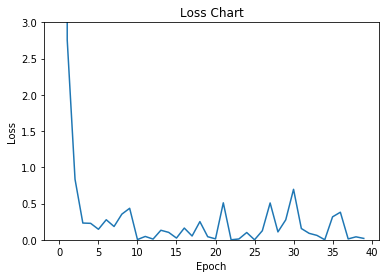

In [38]:
plt.ylim(0,3)#define os limites de exebiçao em y
plt.title('Loss Chart')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(plot_data)

In [40]:
outs_ = []
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('seedlings-model.ckpt.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("Placeholder:0")
    for i in range(len(test_data)):
        feed ={x: [test_data[i][0]], hold_prob:1}

        op_to_restore = tf.nn.softmax(graph.get_tensor_by_name("add_3:0"))

        aaa = sess.run(op_to_restore, feed).ravel().tolist()
        aaa = aaa.index(max(aaa))
        print(dirs[aaa])
        outs_.append([test_data[i][1], dirs[aaa]])

INFO:tensorflow:Restoring parameters from ./seedlings-model.ckpt
Sugar beet
Maize
Small-flowered Cranesbill
Sugar beet
Charlock
Loose Silky-bent
Common Chickweed
Black-grass
Small-flowered Cranesbill
Maize
Charlock
Small-flowered Cranesbill
Common Chickweed
Small-flowered Cranesbill
Cleavers
Black-grass
Common Chickweed
Black-grass
Scentless Mayweed
Fat Hen
Cleavers
Charlock
Scentless Mayweed
Loose Silky-bent
Sugar beet
Common Chickweed
Charlock
Charlock
Small-flowered Cranesbill
Fat Hen
Black-grass
Small-flowered Cranesbill
Maize
Charlock
Black-grass
Loose Silky-bent
Charlock
Cleavers
Cleavers
Shepherds Purse
Loose Silky-bent
Sugar beet
Loose Silky-bent
Fat Hen
Common Chickweed
Small-flowered Cranesbill
Common Chickweed
Fat Hen
Cleavers
Shepherds Purse
Common Chickweed
Scentless Mayweed
Small-flowered Cranesbill
Maize
Charlock
Charlock
Cleavers
Common Chickweed
Scentless Mayweed
Loose Silky-bent
Loose Silky-bent
Common Chickweed
Loose Silky-bent
Black-grass
Charlock
Cleavers
Common Ch

Small-flowered Cranesbill
Loose Silky-bent
Common Chickweed
Loose Silky-bent
Loose Silky-bent
Cleavers
Common Chickweed
Black-grass
Loose Silky-bent
Fat Hen
Scentless Mayweed
Scentless Mayweed
Loose Silky-bent
Small-flowered Cranesbill
Scentless Mayweed
Loose Silky-bent
Loose Silky-bent
Loose Silky-bent
Small-flowered Cranesbill
Small-flowered Cranesbill
Loose Silky-bent
Shepherds Purse
Black-grass
Small-flowered Cranesbill
Sugar beet
Scentless Mayweed
Charlock
Scentless Mayweed
Small-flowered Cranesbill
Fat Hen
Black-grass
Black-grass
Charlock
Black-grass
Loose Silky-bent
Common wheat
Common Chickweed
Loose Silky-bent
Scentless Mayweed
Small-flowered Cranesbill
Loose Silky-bent
Scentless Mayweed
Loose Silky-bent
Maize
Common Chickweed
Cleavers
Common Chickweed
Fat Hen
Black-grass
Charlock
Cleavers
Small-flowered Cranesbill
Loose Silky-bent
Scentless Mayweed
Sugar beet
Loose Silky-bent
Shepherds Purse
Black-grass
Common Chickweed
Common wheat
Scentless Mayweed
Loose Silky-bent
Small-fl

## Writing csv submition

In [41]:
import csv
with open('submition.csv', 'w') as csvfile:
    fieldnames = ['file', 'species']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for i in range(len(outs_)):
        writer.writerow({'file': outs_[i][0], 'species':outs_[i][1]})
    print("csv file ready")

csv file ready
